# SVM
* `LinearSVC(C = , loss = "hinge")`
* `SGDClassifier(loss = "hinge", alpha = 1/(m*C))` - 온라인 학습 지원
* `SVC(kernel = , C = )` - kernel기법 지원, 젤 느림
> p차원 벡터 point들을 p-1차원의 결정경계 초평면으로 분리한다.<br/>
데이터들을 분리하는 초평면들 중 해당 초평면과 가장 가까운 각 클레스 데이터 점들(support vector) 까지의<br/> 거리(margin)가 최대가 되도록 하는 최대마진 초평면을 선택

In [4]:
import numpy as np
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]
y = (iris["target"] == 2).astype(np.float64)

svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linaer_svc", LinearSVC(C = 1, loss = "hinge")),
    # same with SVC(kernel = "linear", C = 1) (slower)
])

svm_clf.fit(X, y)
svm_clf.predict([[5.5, 1.7]])

array([1.])

# non linear svm classification
- feature들을 고차원으로 변환
- 커널트릭

In [5]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples = 100, noise = 0.15)
polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree = 3)),   # 고차원 특성 추가
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C = 10, loss = "hinge"))
])
polynomial_svm_clf.fit(X, y)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge'))])

In [10]:
poly = PolynomialFeatures(3)
X = np.arange(6).reshape(3, 2)
print(X)
X_trans = poly.fit_transform(X)
print(X_trans)

[[0 1]
 [2 3]
 [4 5]]
[[  1.   0.   1.   0.   0.   1.   0.   0.   0.   1.]
 [  1.   2.   3.   4.   6.   9.   8.  12.  18.  27.]
 [  1.   4.   5.  16.  20.  25.  64.  80. 100. 125.]]


In [12]:
from sklearn.svm import SVC

X, y = make_moons(n_samples = 100, noise = 0.15)
poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5)) # 3차 다항식 커널 사용
    ])
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

유사도 특성을 추가하여 데이터 고차원으로 변환
- radial basis function
<img src = "https://github.com/changdaeoh/HandsOn_ML/blob/main/images/5_8.png?raw=true">

In [13]:
poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma = 5, C = 0.001)) # RBF 커널
        # gamma는 정규분포의 sigma의 역수와 같은 의미 
        # 값이 작을수록 분포의 산포가 커지고 캆이 클수록 분포의 산포가 작아짐
        # -> 분포의 산포는 각 샘플의 영향범위
    ])
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

# SVM Regression
loss function
<img src = "https://github.com/changdaeoh/HandsOn_ML/blob/main/images/5_svm_regressor_loss.png?raw=true">

In [ ]:
# from sklearn.svm import SVR, LinearSVR

# svm_reg = LinearSVR(epsion = 1.5)
# svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
# - epsilon parameter로 허용 노이즈정도를 설정

# SVM-Anova : SVM with univariate feature selection

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

### data import

In [4]:
X, y = load_iris(return_X_y=True)
# Add non-informative features 
np.random.seed(0)
X = np.hstack((X, 2 * np.random.random((X.shape[0], 36)))

# np.hstack : 전달한 튜플의 어레이들을 horizontal 방향으로 합침

### make pipeline

In [6]:
# Create a feature-selection transform, a scaler and an instance of SVM that we
# combine together to have an full-blown(모든 특성을 갖춘) estimator
clf = Pipeline([('anova', SelectPercentile(chi2)),
                ('scaler', StandardScaler()),
                ('svc', SVC(gamma = "auto"))])

In [9]:
?SelectPercentile # input X, y에 대한 scoring function 값을 기준으로 지정비율만큼 특성선택

In [8]:
?chi2 # 범주형 타겟변수 y와 non-negative feature x간에 chi-squared 통계량 계산

### results

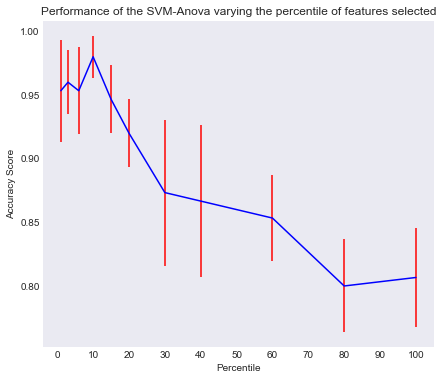

In [20]:
score_means = list()
score_stds = list()
# 사용하는 feature 비율
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile = percentile) # 파이프라인 component의 파라미터 설정 (__)
    this_scores = cross_val_score(clf, X, y)
    score_means.append(this_scores.mean())         # 폴드 평균점수
    score_stds.append(this_scores.std())           # 폴드 표준편차

plt.style.use("seaborn-dark")
plt.figure(figsize = (7, 6))
plt.errorbar(percentiles, score_means, yerr = np.array(score_stds),
             color = "blue", ecolor = "red")
plt.title('Performance of the SVM-Anova varying the percentile of features selected')
plt.xticks(np.linspace(0, 100, 11, endpoint=True))
plt.xlabel('Percentile')
plt.ylabel('Accuracy Score')
plt.axis('tight')
plt.show()

In [11]:
?cross_val_score # 각 fold별 점수를 모아 array로 반환

In [22]:
?plt.errorbar # y vs x line plot에다가 에러바 추가해서 그리기